# Support Vector Machines (SVM)
Irene Pico López

In [1]:
import numpy as np
import pandas as pd
import requests
from io import StringIO
from sklearn.datasets import fetch_openml
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.gaussian_process.kernels import RationalQuadratic, ExpSineSquared
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel
from time import time

import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')

## 1. Carga de datos

Fechas train : 2010-04-01 00:00:00 --- 2023-12-29 00:00:00  (n=3517)
Fechas test 1 : 2024-01-02 00:00:00 --- 2024-01-31 00:00:00  (n=22)
Fechas test 2 : 2024-02-01 00:00:00 --- 2024-04-30 00:00:00  (n=62)
Fechas test 3 : 2024-05-02 00:00:00 --- 2024-07-31 00:00:00  (n=65)


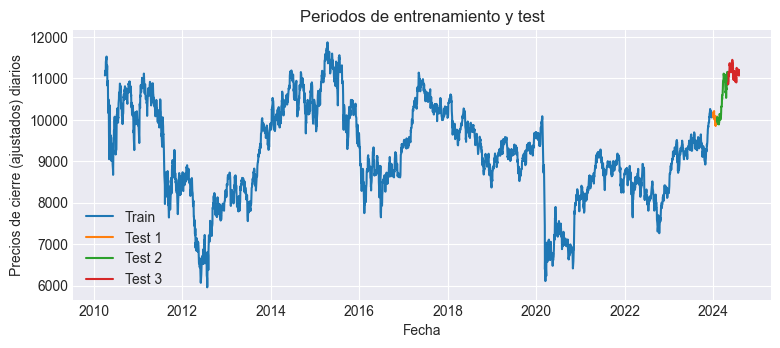

In [2]:
# Cargar los datos desde un archivo HDF5
ibex35 = pd.read_hdf('ibex35.h5', key='datos_tratados')
datos = pd.DataFrame(ibex35['adj_close'])

## TRAIN Y TEST ####
## train (:finTrain)
fin_train = '2023-12-31'
## test1 (enero)
ini_test1 = '2024-01-01'
fin_test1 = '2024-01-31'
## test2 (febrero-abril)
ini_test2 = '2024-02-01'
fin_test2 = '2024-04-30'
## test3 (mayo-julio) (inicioT3:)
ini_test3 = '2024-05-01'
print(
    f"Fechas train : {datos.index.min()} --- {datos.loc[:fin_train].index.max()}  "
    f"(n={len(datos.loc[:fin_train])})"
)
print(
    f"Fechas test 1 : {datos.loc[ini_test1:].index.min()} --- {datos.loc[:fin_test1].index.max()}  "
    f"(n={len(datos.loc[ini_test1:fin_test1])})"
)
print(
    f"Fechas test 2 : {datos.loc[ini_test2:].index.min()} --- {datos.loc[:fin_test2].index.max()}  "
    f"(n={len(datos.loc[ini_test2:fin_test2])})"
)
print(
    f"Fechas test 3 : {datos.loc[ini_test3:].index.min()} --- {datos.loc[:].index.max()}  "
    f"(n={len(datos.loc[ini_test3:])})"
)
datos_train = datos.loc[:fin_train]
datos_test  = datos.loc[ini_test1:]
datos_test1  = datos.loc[ini_test1:fin_test1]
datos_test2  = datos.loc[ini_test2:fin_test2]
datos_test3  = datos.loc[ini_test3:]

# Gráfico
# ======================================================================================
fig, ax = plt.subplots(figsize=(9, 3.5))

# Usar matplotlib directamente para más control sobre las etiquetas
ax.plot(datos_train.index, datos_train['adj_close'], label='Train')
ax.plot(datos_test1.index, datos_test1['adj_close'], label='Test 1')
ax.plot(datos_test2.index, datos_test2['adj_close'], label='Test 2')
ax.plot(datos_test3.index, datos_test3['adj_close'], label='Test 3')



# Títulos y etiquetas de los ejes
ax.set_title('Periodos de entrenamiento y test')
ax.set_xlabel('Fecha')
ax.set_ylabel('Precios de cierre (ajustados) diarios')
# Mostrar leyenda
ax.legend()
# Mostrar el gráfico
plt.show()

In [3]:
# Guardo los datos en un DataFrame de Pandas
df = pd.DataFrame(datos_train)
df = df.reset_index()

# Preprocesamiento de datos: Convertir fechas a valores numéricos
df['Date'] = pd.to_datetime(df['Date'])
df['Decimal_Date'] = (df['Date'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1D')

X = df['Decimal_Date']
X = X.to_frame()
y = df['adj_close']
df

,Date,adj_close,Decimal_Date
0,2010-04-01,11067.889648,14700
1,2010-04-06,11160.587891,14705
2,2010-04-07,11191.288086,14706
3,2010-04-08,11076.289062,14707
4,2010-04-09,11394.188477,14708
...,...,...,...
3512,2023-12-21,10104.299805,19712
3513,2023-12-22,10111.900391,19713
3514,2023-12-27,10121.799805,19718
3515,2023-12-28,10086.200195,19719


In [4]:
from sklearn.gaussian_process.kernels import RBF, ExpSineSquared, RationalQuadratic, WhiteKernel, DotProduct, Exponentiation, ConstantKernel as C

# Tendencia alcista a largo plazo
k1 = C(50, (1e-4, 1e+4)) * RBF(50, (1e-4, 1e+4))

# Componente estacional con estacionalidad anual
k2 = C(5, (1e-4, 1e+4)) * RBF(25, (1e-4, 1e+4)) * ExpSineSquared(length_scale=1.0, length_scale_bounds=(1e-1, 1e3), periodicity=12.0, periodicity_bounds="fixed")

# Irregularidades a medio plazo
k3 = C(0.5, (1e-4, 1e+4)) * RationalQuadratic(length_scale=1.0, length_scale_bounds=(1e-3, 1e3), alpha=1.0, alpha_bounds=(1e-3, 1e3))

# Variaciones a corto plazo
k4 = C(0.1, (1e-2, 1e+2)) * RBF(0.1, (1e-4, 1e+4)) + WhiteKernel(noise_level=0.05, noise_level_bounds=(0.0001, 1))

# Componente de Tendencia Polinomial
k5 = C(0.5, (1e-4, 1e+4)) * Exponentiation(DotProduct(sigma_0=1.0, sigma_0_bounds=(1e-4, 1e4)), exponent=2.0)

# Kernel compuesto
kernel = k1 + k2 + k3 + k4 + k5

gp = GaussianProcessRegressor(kernel=kernel, 
                              alpha=4,  # regularización
                              normalize_y=True,
                              n_restarts_optimizer=5,
                              random_state=2)
gp.fit(X, y)

GaussianProcessRegressor(alpha=4,
                         kernel=7.07**2 * RBF(length_scale=50) + 2.24**2 * RBF(length_scale=25) * ExpSineSquared(length_scale=1, periodicity=12) + 0.707**2 * RationalQuadratic(alpha=1, length_scale=1) + 0.316**2 * RBF(length_scale=0.1) + WhiteKernel(noise_level=0.05) + 0.707**2 * DotProduct(sigma_0=1) ** 2.0,
                         n_restarts_optimizer=5, normalize_y=True,
                         random_state=2)

In [5]:
print("\nLearned kernel: %s" % gp.kernel_)
print("Log-marginal-likelihood: %.3f"
      % gp.log_marginal_likelihood(gp.kernel_.theta))


Learned kernel: 1.13**2 * RBF(length_scale=0.00299) + 13.8**2 * RBF(length_scale=679) * ExpSineSquared(length_scale=9.48, periodicity=12) + 24.3**2 * RationalQuadratic(alpha=0.00301, length_scale=1.08) + 0.135**2 * RBF(length_scale=0.266) + WhiteKernel(noise_level=0.000243) + 0.0323**2 * DotProduct(sigma_0=5.94) ** 2.0
Log-marginal-likelihood: -8569.802


In [6]:
## REALIZO MIS PREDICCIONES
X_ = np.linspace(X.max(), X.max() + 149, 149)[:, np.newaxis] # expando mis predicciones: 149 dias adicionales (espacio test)
## OJO: 149 son el nº de puntos/observaciones que quiero que me devuelva, es decir, deben ser tantos como obervaciones de test tengo

X_ = X_.reshape(-1, 1) # me aseguro de que X_ sea un array 1D
X_df = pd.DataFrame({'Decimal_Date': X_.flatten()}) # creo DataFrame con los datos de entrada X_

## prediciones
y_pred, y_std = gp.predict(X_df, return_std=True)

In [7]:
## Guardo las predicciones en un DataFrame junto con los datos originales
# dfResultados = datos['adj_close']
# dfResultados = dfResultados.to_frame()
# dfResultados['pred'] = y_pred
# dfResultados
dfResultados = pd.DataFrame(y_pred, columns = ['pred'])
dfResultados.index = datos_test.index
dfResultados

,pred
Date,
2024-01-02,10103.778765
2024-01-03,10007.722366
2024-01-04,10047.453533
2024-01-05,9993.123449
2024-01-08,10008.651217
...,...
2024-07-25,10050.785430
2024-07-26,10046.519505
2024-07-29,10073.235019


## Visualización de los resultados

In [8]:
## Separo los periodos de predicción
#######################################

## Escenario 1
pred_test1 = dfResultados['pred'][:22]
## Esceario 2 
pred_test2 = dfResultados['pred'][22:84]
## Escenario 3
pred_test3 = dfResultados['pred'][84:]

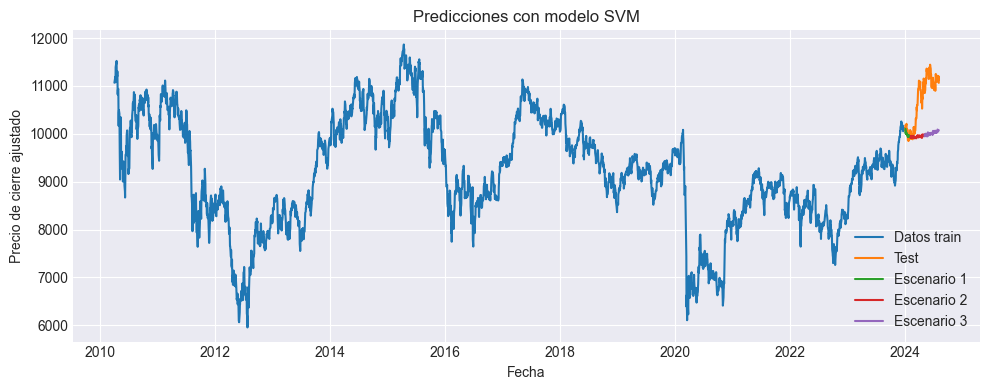

In [9]:
# plot the prediction
fig = plt.figure(figsize=(10,4))
plt.plot(datos_train, label='Datos train')
plt.plot(datos_test, label='Test')
plt.plot(pred_test1, label = 'Escenario 1') 
plt.plot(pred_test2, label = 'Escenario 2') 
plt.plot(pred_test3, label = 'Escenario 3') 
# plt.fill_between(dfResultados.index, 
#                  y_pred - y_std, y_pred + y_std, # intervalo de confianza
#                  alpha=0.5, color='k', label='Incertidumbre')
plt.grid(True)
plt.xlabel("Fecha")
plt.ylabel("Precio de cierre ajustado")
plt.title("Predicciones con modelo SVM")
plt.legend()
plt.tight_layout()
plt.show()

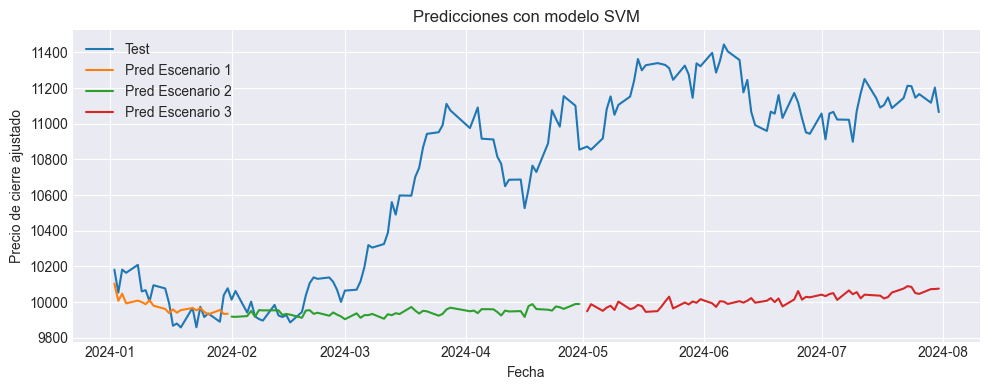

In [10]:
# plot the prediction
fig = plt.figure(figsize=(10,4))
plt.plot(datos_test, label='Test')
plt.plot(pred_test1, label = 'Pred Escenario 1') #, color='yellow'
plt.plot(pred_test2, label = 'Pred Escenario 2') #, color='#5dc460'
plt.plot(pred_test3, label = 'Pred Escenario 3') #, color='blue'
# plt.fill_between(dfResultados.index, 
#                  y_pred - y_std, y_pred + y_std, # intervalo de confianza
#                  alpha=0.5, color='k', label='Incertidumbre')
plt.grid(True)
plt.xlabel("Fecha")
plt.ylabel("Precio de cierre ajustado")
plt.title("Predicciones con modelo SVM")
plt.legend()
plt.tight_layout()
plt.show()

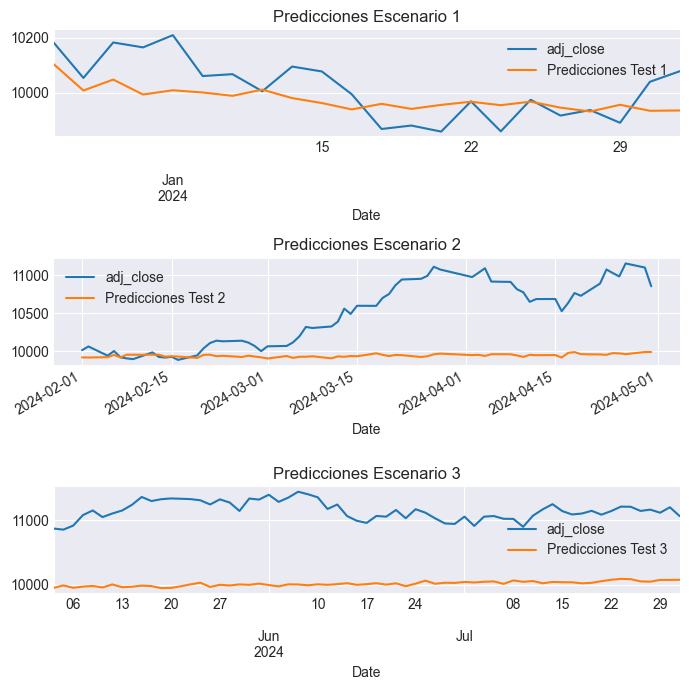

In [11]:
# Crear una figura con tres subplots
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(7, 7))

# Escenario 1
datos_test1.plot(ax=axes[0], label='Adj Close')
pred_test1.plot(ax=axes[0], label='Predicciones Test 1')
axes[0].set_title('Predicciones Escenario 1')
axes[0].legend()

# Escenario 2
datos_test2.plot(ax=axes[1], label='Datos de prueba (Test 2)')
pred_test2.plot(ax=axes[1], label='Predicciones Test 2')
axes[1].set_title('Predicciones Escenario 2')
axes[1].legend()

# Escenario 3
datos_test3.plot(ax=axes[2], label='Datos de prueba (Test 3)')
pred_test3.plot(ax=axes[2], label='Predicciones Test 3')
axes[2].set_title('Predicciones Escenario 3')
axes[2].legend()

# Ajustar el espacio entre los subplots para que no se superpongan los títulos y etiquetas
plt.tight_layout()

# Mostrar la figura combinada
plt.show()

## Métricas de validación

In [12]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calcular métricas para predicciones de statsmodels
## ESCENARIO 1
mae_SVM = mean_absolute_error(datos_test1, pred_test1)
mse_SVM = mean_squared_error(datos_test1, pred_test1)
rmse_SVM = np.sqrt(mse_SVM)
print("Métricas de validación (Escenario 1):")
print(f"MAE: {mae_SVM:.4f}")
print(f"MSE: {mse_SVM:.4f}")
print(f"RMSE: {rmse_SVM:.4f}")
print('\n')

## ESCENARIO 2
mae_SVM = mean_absolute_error(datos_test2, pred_test2)
mse_SVM = mean_squared_error(datos_test2, pred_test2)
rmse_SVM = np.sqrt(mse_SVM)
print("Métricas de validación (Escenario 2):")
print(f"MAE: {mae_SVM:.4f}")
print(f"MSE: {mse_SVM:.4f}")
print(f"RMSE: {rmse_SVM:.4f}")
print('\n')

## ESCENARIO 3
mae_SVM = mean_absolute_error(datos_test3, pred_test3)
mse_SVM = mean_squared_error(datos_test3, pred_test3)
rmse_SVM = np.sqrt(mse_SVM)
print("Métricas de validación (Escenario 3):")
print(f"MAE: {mae_SVM:.4f}")
print(f"MSE: {mse_SVM:.4f}")
print(f"RMSE: {rmse_SVM:.4f}")

Métricas de validación (Escenario 1):
MAE: 79.9884
MSE: 9194.4075
RMSE: 95.8875


Métricas de validación (Escenario 2):
MAE: 543.0510
MSE: 459465.4878
RMSE: 677.8388


Métricas de validación (Escenario 3):
MAE: 1139.5551
MSE: 1322295.2861
RMSE: 1149.9110
